# **Non-Linear Support Vector Machines (from Scratch)**

This tutorial will guide you through the implementation of non-linear support vector machines in Python. While scikit-learn is a useful tool for utilizing support vector machines, it is largely a black box that does not help you gain a deeper understanding of the concepts covered in the lecture.

Therefore, we will be using only numpy and a well-known convex optimization library called CVXOPT in this tutorial. By building the SVM from scratch, you will have a better understanding of the mathematical concepts behind SVMs and how they are optimized.

Let's first import some libraries:

In [ ]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers
from matplotlib.colors import ListedColormap
np.random.seed(seed=1986)

Let's also define a function that will help us with plots:

In [ ]:
def plot_data(X, y, model=None, plot_boundaries=False, plot_svect=False):

    # hyperparameter for boardry
    x_min = X[:,0].min()-0.5
    x_max = X[:,0].max()+0.5
    y_min = X[:,1].min()-0.5
    y_max = X[:,1].max()+0.5
    step = 0.05

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                        np.arange(y_min, y_max, step)
                        )
    if plot_boundaries:
      z = model.predict(np.c_[xx.ravel(), yy.ravel()])
      z = z.reshape(xx.shape)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#003300'])

    plt.figure(figsize=(8, 5), dpi=96)

    if plot_boundaries:
      plt.pcolormesh(xx, yy, z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    if plot_svect:
      X_sv = X[model.sp_v_i]
      plt.scatter(X_sv[:, 0], X_sv[:, 1], s=200,
                c="None", edgecolors=["blue"], marker="o", label="support vector")

    plt.show()

# **Dataset**
Now, we create a dataset composed of two non-linearly separable classes.
In particular, we sample data such that we approximately form two ellipses one inside the other:

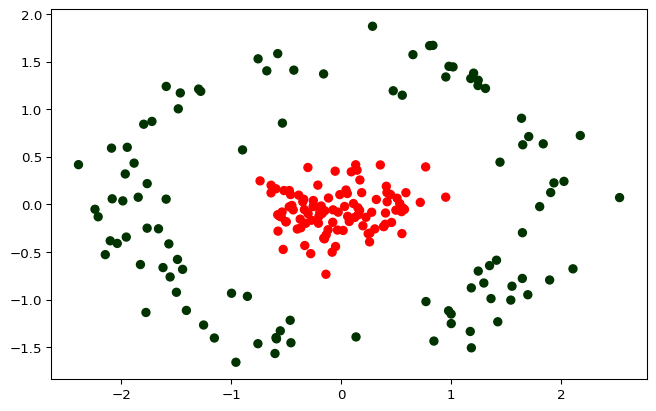

In [ ]:
def elipse_samples(N, u=1, v=0.5, a=2., b=1.5, sigma_noise = 0.1):
  """Draws data from an elipse function (by addding a small noise)

  Arguments:
   N (int): Number of data points to sample
   u (float): x-position of the center
   v (float): y-position of the center
   a (float): radius on the x-axis
   b (float): radius on the y-axis
   sigma_noise: standard deviation applied to the additive noise

  Returns
  x (np.array): samples drawn from the ellipse
  """
  t = np.random.uniform(low=0.0, high=2*math.pi, size=N)
  x1 = u+a*np.cos(t) + np.random.normal(loc=0.0, scale=sigma_noise, size=N)
  x2 =  v+b*np.sin(t) +  np.random.normal(loc=0.0, scale=sigma_noise , size=N)
  return np.stack([x1,x2]).T


def get_dataset(N=100,
                mu0 = np.array([0,0]),
                cov0 = np.array([[0.5,0],[0,0.5]]),
                mu1 = np.array([2,2]),
                cov1 = np.array([[0.5,0],[0,0.5]]),
                sigma_noise = 0.2
                ):
  """Creates data for binary classification by drawing samples from the ellipse"""

  # Class 0 samples
  x0 = elipse_samples(N, u=0, v=0, a=2., b=1.5, sigma_noise=sigma_noise)
  y0 = np.ones(x0.shape[0])

  # Class 1 samples
  x1 = elipse_samples(N, u=0, v=0, a=0.5, b=0.1, sigma_noise=sigma_noise)
  y1 = -np.ones(x1.shape[0])

  X = np.concatenate([x0,x1])
  y = np.concatenate([y0,y1])
  return X,y

X, y = get_dataset()
plot_data(X, y)

## **Non-linear Hard-Margin SVM**

The problem that we have to solve in a non-linear hard-margin SVM is the following (see the main lecture of this week):


$\mathbf{a^*} = \underset{\mathbf{a}}{\operatorname{argmax}} \; \mathbf{1}^T \mathbf{a} - \frac{1}{2} \mathbf{a}^T\mathbf{H}\mathbf{a}$

s.t.

$\mathbf{t}^T \mathbf{a}=0$

$\mathbf{a} \geq \mathbf{0}$


Where:

- $\mathbf{a} = [a_1, a_2, ..., a_N]^T$ are the N Lagrange multipliers

- $\mathbf{t} = [t_1, t_2, ..., t_N]^T$ are the N labels

- $\mathbf{1} = [1, 1, ..., 1]^T$ is a vector composed of N ones

- $\mathbf{0} = [0, 0, ..., 0]^T$ is a matrix composed of N zeros.

The matrix $\mathbf{H}$ is defined as follows:

$\mathbf{H} = \mathbf{t} \mathbf{t}^T \mathbf{K}$

Where:
- $
\mathbf{K} = \begin{bmatrix}
k(\mathbf{x}_1, \mathbf{x}_1) & k(\mathbf{x}_1, \mathbf{x}_2) & ... & k(\mathbf{x}_1, \mathbf{x}_N) \\
k(\mathbf{x}_2, \mathbf{x}_1) & k(\mathbf{x}_2, \mathbf{x}_2) & ... & k(\mathbf{x}_2, \mathbf{x}_N) \\
... & ...& ...& ... \\
k(\mathbf{x}_N, \mathbf{x}_1) & k(\mathbf{x}_N, \mathbf{x}_2) & ... & k(\mathbf{x}_N, \mathbf{x}_N) \\
\end{bmatrix}$ is the gram matrix (NxN) that collects the kernels evaluated in each couple of points.

- $\mathbf{x}_i=[x_{i1}, x_{i2}, ..., x_{iD}]^T$ is the i-th input vector (composed of D features).

### **Using the CVXOPT optimizer**
The first challenge is to manipulate the problem such that we can feed it into the CVXOPT optimizer.

The CVXOPT optimizer is indeed designed to solve problems expressed as:

$
\begin{equation*}
\begin{aligned}
& \mathbf{z}^* = \underset{\mathbf{z}}{\operatorname{argmin}} \frac{1}{2} \mathbf{z}^T \mathbf{P} \mathbf{z} + \mathbf{q}^T \mathbf{z} \\
& \text{s.t.} \:
\mathbf{G}\mathbf{z} \leq \mathbf{h} \\
& \text{s.t.} \: \mathbf{A}\mathbf{z} = \mathbf{b}
\end{aligned}
\end{equation*}
$

In this case, our optimization variable is the vector $\mathbf{a}$ containing the N Lagrange multipliers (one for each training sample). Moreover, we need to turn our **maximization** problem into a **minimization** one.

This can be  done in this way:

$\mathbf{a^*} = \underset{\mathbf{a}}{\operatorname{argmax}} \; \mathbf{1}^T\mathbf{a} - \frac{1}{2} \mathbf{a}^T\mathbf{H}\mathbf{a}$


$ \; \; \; \; = \underset{\mathbf{a}}{\operatorname{argmin}} \;  \frac{1}{2} \mathbf{a}^T\mathbf{H}\mathbf{a} -\mathbf{1}^T\mathbf{a}$

In the CVXOPT optimizer, we can simply set $\mathbf{P}=\mathbf{H}=\mathbf{t} \mathbf{t}^T \mathbf{K}$ and $\mathbf{q}=-\mathbf{1}^T$.

We have to set the matrix $\mathbf{A}=\mathbf{t}^T$ and $\mathbf{b}=0$.

Finally, we have to set $\mathbf{G}$ and $\mathbf{h}$ (starting from $\mathbf{a}\geq 0$). We can write this inequality constraint as:

$-\mathbf{I} \mathbf{a} \leq 0 $

where $\mathbf{I}$ is the identity matrix. We can thus set $\mathbf{G}=-\mathbf{I}$ and $\mathbf{h}=\mathbf{0}^T$.

Now, everything is set up and we have all the information to solve our optimization problem with the CVXOPT optimizer.

### **Making a prediction**

Once we have the Lagrange multipliers $\mathbf{a}$, how can we use them to make a prediction? This is something we discussed in the main lecture.
In particular, we can do a prediction using the following equation:

$y(\mathbf{x}) = b + \sum_{i \in S} a_i t_i k(\mathbf{x}_i,\mathbf{x})$

where:
- $\mathbf{x}=[x_1, x_2, .., x_N]^T$ is the input that we want to classify
- S is the set of support vectors (i.e., the data points with a positive Lagrange multiplier)
- $a_i$ is the Lagrange multiplier for the support vector $i$
- $t_i$ is the label for the support vector $i$
- $k(\mathbf{x}_i, \mathbf{x})$ is kernel computed between the support vector \mathbf{x}_i and the input to classify $\mathbf{x}$

On top of $y(\mathbf{x})$ we can apply a decision rule such that we vote for one class if $y(\mathbf{x}) \geq 0$ and for the other xlass otherwise. This can be done with the sign function:

$\hat{t} = sign(y(\mathbf{x}))$

The output will be $1$ for one class and $-1$ for the other.

The bias term can be computed as follows:

$b = t_i - \sum_{j \in S} a_j t_j k(\mathbf{x}_j,\mathbf{x}_i)$

where $\mathbf{x}_i$ is one of the support vectors available in S. Even though it is enough to pick up a random support vector from S, many practical implementations consider all the support vectors and average their b values. This is done to improve stability. So, we implement the following estimate of the bias $b$:


$b = \frac{1}{N_S} \sum_{i=1}^{N_S} \Big( t_i - \sum_{j \in S} a_j t_j k(\mathbf{x}_j,\mathbf{x}_i) \Big)$

where $N_s$ is the number of support vectors.

### **Kernels**
Several kernels have been proposed in the literature. The most common ones are:

- $k(\mathbf{x},\mathbf{x}') = \mathbf{x}^T \mathbf{x}'$ (Linear Kernel)

- $k(\mathbf{x},\mathbf{x}') = (\mathbf{x}^T \mathbf{x}' + c)^d$ (Polynomial Kernel)

- $k(\mathbf{x},\mathbf{x}') = \exp(-\gamma ||\mathbf{x} - \mathbf{x}'||^2)$ (Gaussian Kernel)

The role of the kernel function is to increase the dimensionality of the input data such that we increase the chance the data will be linearly separable in the high-dimensional transformed space.

We now have all the ingredients on the table, we just need to properly cook them into the code.

Let's first write the code for the kernels:

In [ ]:
import numpy as np
from numpy import linalg

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, c=1, d=3):
    return (c + np.dot(x, y)) ** d

def gaussian_kernel(x, y, gamma=0.1):
    return np.exp(-gamma*linalg.norm(x-y)**2)

Now, we can implement the SVM as specified above. We will put the trainign code in the *fit* method and the code for making a prediction in the *precit* one.

In [ ]:
import cvxopt
import cvxopt.solvers

class SVM(object):

    def __init__(self, kernel=linear_kernel):
        self.kernel = kernel

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        self.K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                self.K[i,j] = self.kernel(X[i], X[j])

        # Matrix definition
        P = cvxopt.matrix(np.outer(y,y) * self.K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y.reshape(1,n_samples))
        b = cvxopt.matrix(0.0)

        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        self.sv_tf = a > 1e-5  # sv is vector containing "True" is positions
                       # corresponding to support vectors and False otherwise.
        self.ind = np.arange(len(a))[self.sv_tf] # This variable contains the indexes of the support vectors.
        self.a = a[self.sv_tf]
        self.sv = X[self.sv_tf]
        self.sv_y = y[self.sv_tf]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))


    def predict(self, X):
        # Getting the bias term
        b = 0
        for n in range(len(self.a)):
            b += self.sv_y[n]
            b -= np.sum(self.a * self.sv_y * self.K[self.ind[n],self.sv_tf])
            # Note that the kernel K is computed between the selected support vector
            # self.ind[n] and all the other ones available in the training set.
            # self.sv_tf ensures that we only pick up the support vectors.

        # Average all the bias predictions (with all the support vectors).
        b /= len(self.a)

        # Making a prediction
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return np.sign(y_predict + b)


As you can see, with a few lines of well-designed code we can implement a non-linear hard-margin SVM.

We can now run it with the polynomial kernel:

     pcost       dcost       gap    pres   dres
 0: -2.4399e+01 -5.7180e+01  9e+02  3e+01  2e+00
 1: -4.7006e+01 -4.5011e+01  4e+02  1e+01  9e-01
 2: -1.3692e+01 -7.2330e+00  9e+01  2e+00  2e-01
 3: -1.3877e+00 -3.5993e+00  1e+01  2e-01  2e-02
 4: -1.3812e+00 -2.4927e+00  3e+00  4e-02  3e-03
 5: -1.8437e+00 -2.1743e+00  5e-01  6e-03  5e-04
 6: -1.9527e+00 -2.1568e+00  3e-01  3e-03  2e-04
 7: -1.9865e+00 -2.1596e+00  2e-01  4e-04  3e-05
 8: -2.1283e+00 -2.1403e+00  1e-02  2e-05  2e-06
 9: -2.1393e+00 -2.1395e+00  1e-04  2e-07  2e-08
10: -2.1395e+00 -2.1395e+00  1e-06  2e-09  2e-10
Optimal solution found.
8 support vectors out of 200 points


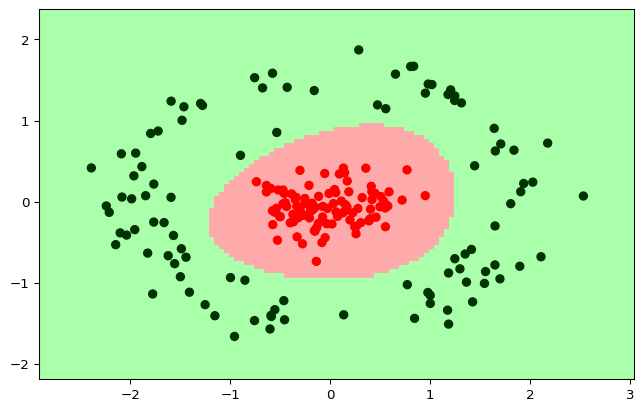

In [ ]:
svm = SVM(kernel = polynomial_kernel)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

     pcost       dcost       gap    pres   dres
 0: -3.5891e+01 -1.1920e+02  8e+02  2e+01  2e+00
 1: -5.9630e+01 -1.8498e+02  4e+02  1e+01  1e+00
 2: -6.3565e+01 -1.8235e+02  2e+02  5e+00  5e-01
 3: -9.5078e+01 -2.1357e+02  2e+02  5e+00  4e-01
 4: -2.5358e+02 -3.5358e+02  2e+02  2e+00  2e-01
 5: -2.7376e+02 -2.8972e+02  3e+01  4e-01  3e-02
 6: -2.7633e+02 -2.7864e+02  2e+00  1e-03  1e-04
 7: -2.7842e+02 -2.7844e+02  2e-02  1e-05  1e-06
 8: -2.7844e+02 -2.7844e+02  2e-04  1e-07  1e-08
 9: -2.7844e+02 -2.7844e+02  2e-06  1e-09  1e-10
Optimal solution found.
6 support vectors out of 200 points


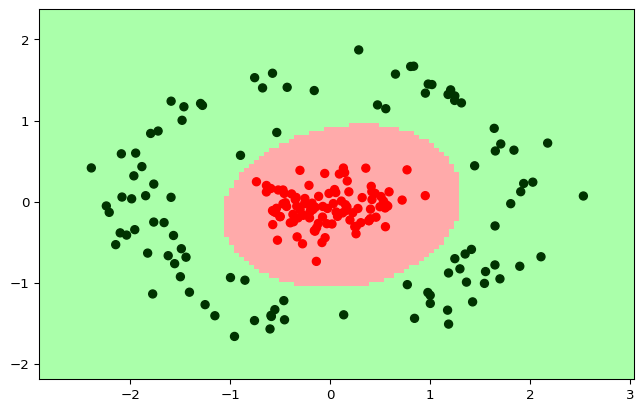

In [ ]:
svm = SVM(kernel = gaussian_kernel)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

The Gaussian kernel finds a good solution as well. Note that the solution found by the polynomial kernels is slightly different from that learned with the gaussian one.

*What do you think is gonna happen if we use the linear kernel?*

Let's give it a try:

     pcost       dcost       gap    pres   dres
 0: -1.9953e+02 -4.2072e+02  2e+02  4e-14  2e+00
 1: -4.7113e+02 -4.7690e+02  6e+00  7e-15  1e+00
 2: -3.8988e+04 -3.8992e+04  5e+00  8e-12  1e+00
 3: -3.0524e+08 -3.0524e+08  4e+02  8e-08  1e+00
 4: -1.8632e+10 -1.8632e+10  3e+04  3e-07  1e+00
Terminated (singular KKT matrix).
200 support vectors out of 200 points


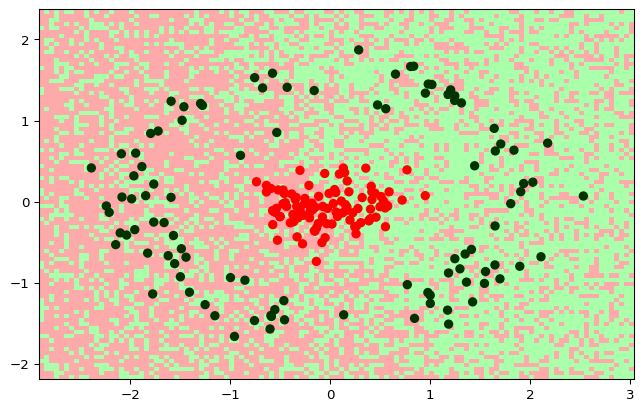

In [ ]:
svm = SVM(kernel = linear_kernel)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

With a linear kernel, we end up with a linear SVM (that can only work with linearly separable classes). The optimizer cannot find a solution and raises and error "Terminated (singular KKT matrix)".

## **Non-Linear Soft-Margin SVM**

In some cases the data can be challenging and even after applying the kernel (that increases the input dimensionality to make the classes more linearly separable) the classes are no be perfectly linearly separable in the high-dimensional transformed space.

For instance, let's create more noisy data where the two classes are more overlapped.



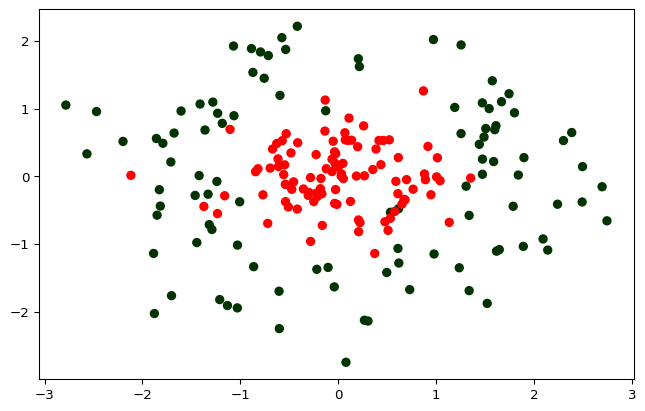

In [ ]:
X, y = get_dataset(sigma_noise = 0.45)
plot_data(X, y)

Let's use the hard-margin SVM implemented in the previous section.
First, let's see what happens with a polynomial kernel:

     pcost       dcost       gap    pres   dres
 0: -7.7106e+01 -2.1394e+02  1e+03  3e+01  3e+00
 1: -2.9474e+02 -5.3934e+02  1e+03  2e+01  2e+00
 2: -8.3778e+02 -1.3182e+03  1e+03  2e+01  2e+00
 3: -2.7117e+03 -3.6694e+03  1e+03  2e+01  1e+00
 4: -8.7724e+03 -1.0240e+04  2e+03  1e+01  1e+00
 5: -2.4612e+04 -2.7667e+04  3e+03  1e+01  1e+00
 6: -7.8031e+04 -8.5384e+04  7e+03  1e+01  1e+00
 7: -3.1339e+05 -3.3521e+05  2e+04  1e+01  1e+00
 8: -2.1165e+06 -2.2084e+06  9e+04  1e+01  1e+00
 9: -2.7960e+07 -2.8556e+07  6e+05  1e+01  1e+00
10: -1.1652e+09 -1.1690e+09  4e+06  1e+01  1e+00
11: -1.3891e+10 -1.3934e+10  4e+07  1e+01  1e+00
12: -1.4015e+10 -1.4059e+10  4e+07  1e+01  1e+00
13: -1.4523e+10 -1.4568e+10  4e+07  1e+01  1e+00
14: -2.9291e+10 -2.9382e+10  9e+07  1e+01  1e+00
15: -1.1841e+11 -1.1878e+11  4e+08  1e+01  1e+00
16: -1.2927e+11 -1.2966e+11  4e+08  1e+01  1e+00
17: -3.8679e+11 -3.8798e+11  1e+09  1e+01  1e+00
18: -4.3580e+11 -4.3714e+11  1e+09  1e+01  1e+00
19: -5.5187e+11 -5.53

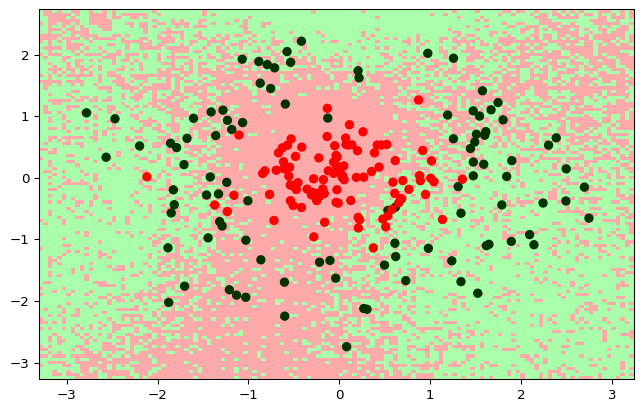

In [ ]:
svm = SVM(kernel = polynomial_kernel)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

If this case, the data are not linearly separable even after applying the polynomial kernel, and the optimization process fails.

Let's try with a Gaussian kernel:

     pcost       dcost       gap    pres   dres
 0: -7.1585e+01 -2.3467e+02  1e+03  2e+01  3e+00
 1: -2.4918e+02 -5.4623e+02  7e+02  1e+01  2e+00
 2: -1.0589e+03 -1.5491e+03  7e+02  1e+01  1e+00
 3: -3.5196e+03 -4.3137e+03  9e+02  1e+01  1e+00
 4: -1.1877e+04 -1.3454e+04  2e+03  9e+00  1e+00
 5: -3.4240e+04 -3.7792e+04  4e+03  9e+00  1e+00
 6: -4.3978e+04 -4.8350e+04  4e+03  9e+00  1e+00
 7: -1.2373e+05 -1.3373e+05  1e+04  9e+00  1e+00
 8: -3.4816e+05 -3.7206e+05  2e+04  9e+00  1e+00
 9: -4.8152e+05 -5.1349e+05  3e+04  9e+00  1e+00
10: -2.3218e+06 -2.4420e+06  1e+05  9e+00  1e+00
11: -2.4368e+06 -2.5617e+06  1e+05  9e+00  1e+00
12: -2.8819e+06 -3.0272e+06  1e+05  9e+00  1e+00
13: -4.9769e+06 -5.2176e+06  2e+05  9e+00  1e+00
14: -9.7747e+06 -1.0231e+07  5e+05  9e+00  1e+00
15: -1.1576e+07 -1.2108e+07  5e+05  9e+00  1e+00
16: -3.3891e+07 -3.5371e+07  1e+06  9e+00  1e+00
17: -6.4964e+07 -6.7740e+07  3e+06  9e+00  1e+00
18: -1.8163e+08 -1.8906e+08  7e+06  9e+00  1e+00
19: -4.7847e+08 -4.96

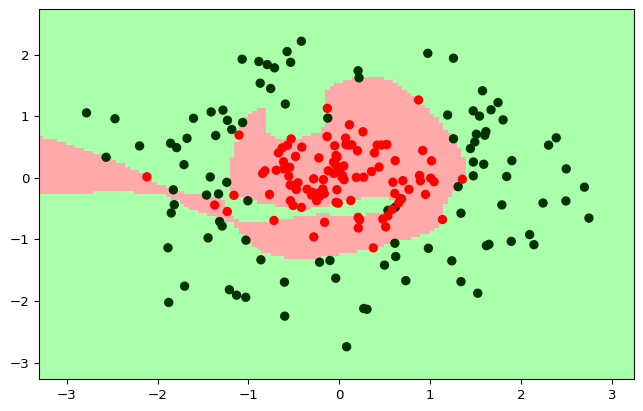

In [ ]:
svm = SVM(kernel = gaussian_kernel)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

In this case, the solution found by the Gaussian kernel is a bit better (but still the optimizer struggles to find a good solution).

The problem is that with a hard margin SVM we force the model to have a perfect classification. It is much better to relax this constraint and allow the model to perform some errors.

This can be done with the soft-margin SVMs mentioned in the lectures.

The optimization problem to solve takes this form:

$\mathbf{a^*} = \underset{\mathbf{a}}{\operatorname{argmax}} \; \mathbf{1}^T \mathbf{a} - \frac{1}{2} \mathbf{a}^T\mathbf{H}\mathbf{a}$

s.t.

$\mathbf{t}^T \mathbf{a}=0$

$ 0 \leq a_i \geq C \: for\: i=\{1,...,N\}$

The problem is identical to the previous one, except for the box constraint (that introduces the hyperparameter C).

We now have to find a way to map the box constraint into what is expected by the CVXOPT optimizer:

$\mathbf{G}\mathbf{a} \leq \mathbf{h}$

To implement the box contain we can set $\mathbf{G}$ in the following way:

$ \mathbf{G}=
\begin{bmatrix}
-1 & 0 & 0 & ... & 0 \\
0 & -1 & 0 & ... & 0 \\
0 & 0 & -1 & ... & 0 \\
... & ... & .. & ... & ... \\
0 & 0 & 0 & ... & -1 \\
1 & 0 & 0 & ... & 0 \\
0 & 1 & 0 & ... & 0 \\
0 & 0 & 1 & ... & 0 \\
... & ... & .. & ... & ... \\
0 & 0 & 0 & ... & 1 \\
\end{bmatrix}
$


$\mathbf{G}$ is a matrix of dimensionality (2N x N) that can be seen as the concatenation on the row axis of two diagonal matrices: the -$\mathbf{I}$ (-identity) and the $\mathbf{I}$ (identity) ones. The first will implement the $\mathbf{a}\geq 0$ constraints, while the other will cover the $\mathbf{a}\leq C$ ones.

Similarly, $\mathbf{h}$ should be set as:


$ \mathbf{h}=
\begin{bmatrix}
0 \\
0 \\
... \\
0 \\
C \\
C \\
... \\
C \\
\end{bmatrix}
$

$\mathbf{h}$ is a vector of dimensioanlity (2N). The first N elements implement the $\mathbf{a}\geq 0$ contraint, while the remaining N implmement the $\mathbf{a}\leq C$ contraint.

We can modify the code above and specify the new values for $\mathbf{G}$ and $\mathbf{h}$.


In [ ]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=1.0):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        self.K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                self.K[i,j] = self.kernel(X[i], X[j])

        # Matrix definition
        P = cvxopt.matrix(np.outer(y,y) * self.K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y.reshape(1,n_samples))
        b = cvxopt.matrix(0.0)

        # Setting G and h
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        self.sv_tf = a > 1e-5  # sv is vector containing "True" is positions
                       # corresponding to support vectors and False otherwise.
        self.ind = np.arange(len(a))[self.sv_tf] # This variable contains the indexes of the support vectors.
        self.a = a[self.sv_tf]
        self.sv = X[self.sv_tf]
        self.sv_y = y[self.sv_tf]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))


    def predict(self, X):
        # Getting the bias term
        b = 0
        for n in range(len(self.a)):
            b += self.sv_y[n]
            b -= np.sum(self.a * self.sv_y * self.K[self.ind[n],self.sv_tf])
            # Note that the kernel K is computed between the selected support vector
            # self.ind[n] and all the other ones available in the training set.
            # self.sv_tf ensures that we only pick up the support vectors.

        # Average all the bias predictions (with all the support vectors).
        b /= len(self.a)

        # Making a prediction
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return np.sign(y_predict + b)

Let's now see what happens with a polynomial kernel.

     pcost       dcost       gap    pres   dres
 0: -7.7044e+01 -5.5302e+02  3e+03  3e+00  1e-13
 1: -4.8704e+01 -3.8726e+02  8e+02  6e-01  1e-13
 2: -3.4473e+01 -1.8302e+02  3e+02  2e-01  6e-14
 3: -2.8338e+01 -8.4686e+01  9e+01  6e-02  3e-14
 4: -2.6954e+01 -4.4359e+01  2e+01  1e-02  4e-14
 5: -2.8044e+01 -3.5971e+01  9e+00  4e-03  3e-14
 6: -2.8819e+01 -3.3479e+01  5e+00  2e-03  3e-14
 7: -2.9581e+01 -3.1359e+01  2e+00  3e-04  4e-14
 8: -2.9978e+01 -3.0627e+01  7e-01  8e-05  3e-14
 9: -3.0198e+01 -3.0281e+01  8e-02  6e-06  4e-14
10: -3.0230e+01 -3.0235e+01  5e-03  3e-07  3e-14
11: -3.0232e+01 -3.0232e+01  5e-05  3e-09  3e-14
12: -3.0232e+01 -3.0232e+01  5e-07  3e-11  3e-14
Optimal solution found.
37 support vectors out of 200 points


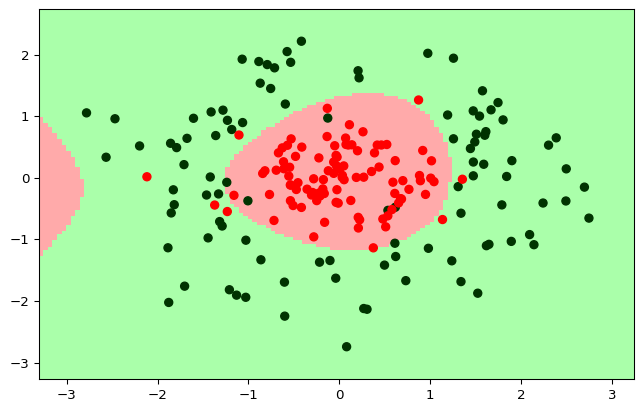

In [ ]:
svm = SVM(kernel = polynomial_kernel)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

As you can see, the solution now looks much more natural. We have some training samples that are misclassified, but at least we do not overfit unnaturally as before.


As done in the previous tutorial, we can play with the hyperparameter C:

     pcost       dcost       gap    pres   dres
 0: -3.8970e+01 -4.2232e+00  1e+03  4e+01  8e-14
 1: -1.2260e+00 -4.1956e+00  3e+01  6e-01  6e-14
 2: -6.5185e-01 -3.2477e+00  5e+00  9e-02  9e-15
 3: -4.8941e-01 -1.2822e+00  8e-01  3e-03  2e-15
 4: -5.9221e-01 -7.4473e-01  2e-01  4e-04  1e-15
 5: -6.3484e-01 -6.8731e-01  5e-02  1e-04  8e-16
 6: -6.5115e-01 -6.6492e-01  1e-02  2e-05  1e-15
 7: -6.5601e-01 -6.5885e-01  3e-03  4e-06  1e-15
 8: -6.5722e-01 -6.5744e-01  2e-04  2e-07  1e-15
 9: -6.5731e-01 -6.5734e-01  3e-05  4e-09  1e-15
10: -6.5733e-01 -6.5733e-01  3e-07  5e-11  1e-15
Optimal solution found.
87 support vectors out of 200 points


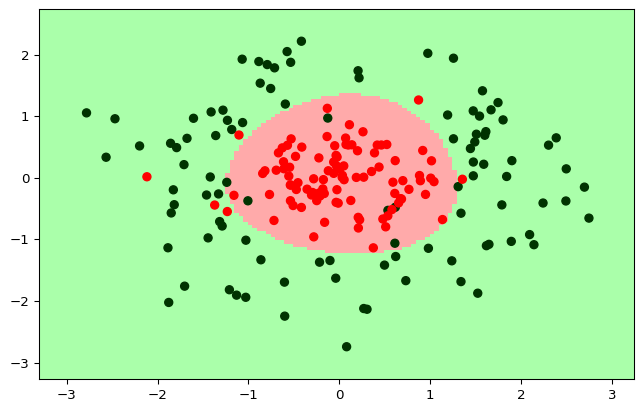

In [ ]:
svm = SVM(kernel = polynomial_kernel, C=0.01)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

     pcost       dcost       gap    pres   dres
 0: -3.2616e+03 -1.8021e+06  5e+06  1e+00  7e-12
 1: -7.2422e+02 -8.5089e+05  1e+06  2e-01  8e-12
 2:  1.3947e+03 -2.6531e+05  4e+05  4e-02  4e-12
 3: -6.1697e+01 -8.7721e+04  1e+05  1e-02  3e-12
 4: -1.5607e+03 -2.9086e+04  3e+04  3e-13  3e-12
 5: -2.0177e+03 -7.3418e+03  5e+03  4e-13  2e-12
 6: -2.1662e+03 -7.1111e+03  5e+03  4e-14  2e-12
 7: -2.3358e+03 -4.8810e+03  3e+03  1e-13  3e-12
 8: -2.4902e+03 -4.0918e+03  2e+03  6e-13  2e-12
 9: -2.6286e+03 -3.6928e+03  1e+03  3e-13  3e-12
10: -2.6078e+03 -3.4121e+03  8e+02  1e-13  4e-12
11: -2.6801e+03 -3.3602e+03  7e+02  4e-13  3e-12
12: -2.7881e+03 -3.1008e+03  3e+02  2e-13  3e-12
13: -2.7936e+03 -3.1031e+03  3e+02  2e-13  5e-12
14: -2.8603e+03 -2.9710e+03  1e+02  8e-14  3e-12
15: -2.8771e+03 -2.9268e+03  5e+01  3e-13  3e-12
16: -2.8910e+03 -2.9085e+03  2e+01  2e-13  3e-12
17: -2.8985e+03 -2.8993e+03  8e-01  5e-13  4e-12
18: -2.8988e+03 -2.8988e+03  8e-03  5e-13  5e-12
19: -2.8988e+03 -2.89

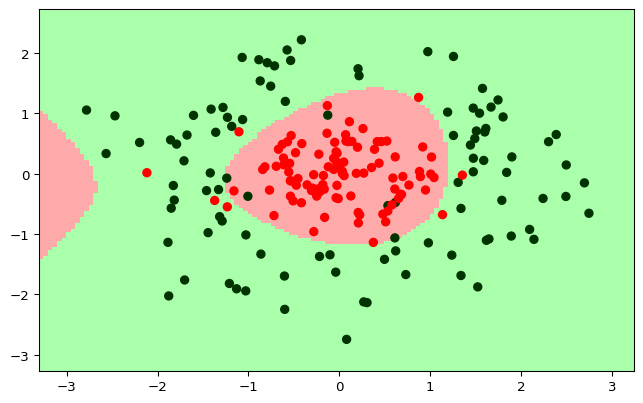

In [ ]:
svm = SVM(kernel = polynomial_kernel, C=100)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

With large values of C, we tolerate a smaller number of errors, but we risk overfitting more.

Let's see what happens with a Gaussian Kernel:

     pcost       dcost       gap    pres   dres
 0: -6.9429e+01 -4.7186e+02  2e+03  3e+00  6e-15
 1: -4.4956e+01 -3.0410e+02  3e+02  5e-02  8e-15
 2: -5.4927e+01 -8.9620e+01  4e+01  7e-03  6e-15
 3: -6.5675e+01 -7.4048e+01  8e+00  1e-03  7e-15
 4: -6.8317e+01 -7.1415e+01  3e+00  3e-04  7e-15
 5: -6.9339e+01 -7.0191e+01  9e-01  6e-05  7e-15
 6: -6.9699e+01 -6.9773e+01  7e-02  4e-06  8e-15
 7: -6.9732e+01 -6.9734e+01  2e-03  9e-08  8e-15
 8: -6.9733e+01 -6.9733e+01  2e-05  9e-10  8e-15
Optimal solution found.
94 support vectors out of 200 points


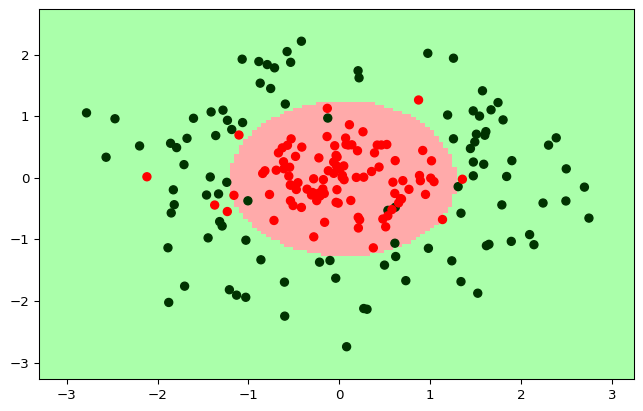

In [ ]:
svm = SVM(kernel = gaussian_kernel)
svm.fit(X,y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

The solution now looks pretty good with the Gaussian kernel as well.

Let's now run the model on even more complex data. For instance, let's generate the so-called spiral data:

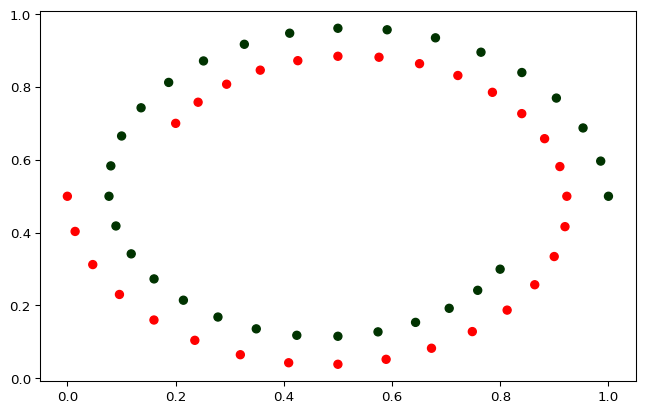

In [ ]:
import math

def spiral_xy(i, spiral_num):
    """
    Create the data for a spiral.

    Arguments:
        i runs from 0 to 96
        spiral_num is 1 or -1
    """
    φ = i/16 * math.pi
    r = 6.5 * ((104 - i)/104)
    x = (r * math.cos(φ) * spiral_num)/13 + 0.5
    y = (r * math.sin(φ) * spiral_num)/13 + 0.5
    return (x, y)

def spiral(spiral_num):
    return [spiral_xy(i, spiral_num) for i in range(30)]


a = np.asarray(spiral(1))
a_label = np.ones(a.shape[0])
b = np.asarray(spiral(-1))
b_label = -np.ones(b.shape[0])

X = np.concatenate([a,b],axis=0)
y = np.concatenate([a_label,b_label],axis=0)

plot_data(X, y)

     pcost       dcost       gap    pres   dres
 0: -5.8760e+01 -1.2912e+02  3e+02  2e+00  2e-14
 1: -4.6509e+01 -8.7150e+01  4e+01  9e-16  2e-14
 2: -5.3704e+01 -5.7263e+01  4e+00  4e-15  3e-14
 3: -5.4815e+01 -5.5587e+01  8e-01  3e-15  3e-14
 4: -5.5166e+01 -5.5283e+01  1e-01  7e-15  3e-14
 5: -5.5214e+01 -5.5234e+01  2e-02  9e-16  3e-14
 6: -5.5223e+01 -5.5224e+01  6e-04  3e-15  3e-14
 7: -5.5224e+01 -5.5224e+01  9e-06  4e-16  3e-14
Optimal solution found.
57 support vectors out of 60 points


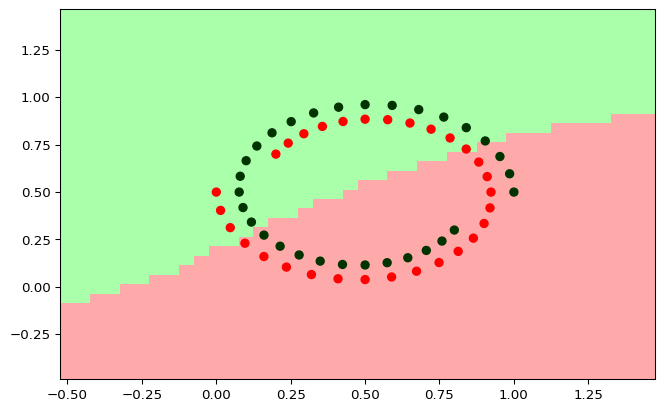

     pcost       dcost       gap    pres   dres
 0: -2.5420e+03 -5.9706e+04  6e+04  2e-13  1e-12
 1: -2.9235e+03 -6.9700e+03  4e+03  3e-13  2e-12
 2: -4.4600e+03 -5.1006e+03  6e+02  5e-13  2e-12
 3: -4.6105e+03 -4.7760e+03  2e+02  6e-13  2e-12
 4: -4.6478e+03 -4.6937e+03  5e+01  1e-13  3e-12
 5: -4.6534e+03 -4.6863e+03  3e+01  5e-13  2e-12
 6: -4.6631e+03 -4.6723e+03  9e+00  6e-13  2e-12
 7: -4.6656e+03 -4.6694e+03  4e+00  2e-13  2e-12
 8: -4.6667e+03 -4.6680e+03  1e+00  5e-13  3e-12
 9: -4.6671e+03 -4.6674e+03  2e-01  3e-13  3e-12
10: -4.6672e+03 -4.6672e+03  2e-02  5e-13  3e-12
11: -4.6672e+03 -4.6672e+03  4e-04  2e-13  3e-12
Optimal solution found.
60 support vectors out of 60 points


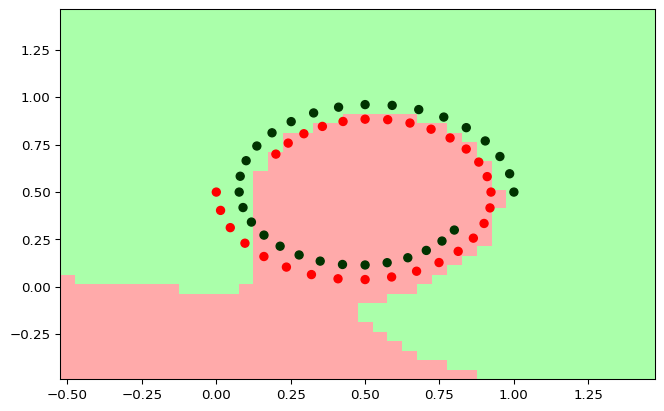

     pcost       dcost       gap    pres   dres
 0:  3.9603e+06 -5.3235e+08  5e+08  1e-17  1e-10
 1:  1.7322e+06 -2.4237e+07  3e+07  1e-11  2e-10
 2:  7.3970e+05 -3.2476e+06  4e+06  1e-11  1e-10
 3:  1.4054e+05 -7.2149e+05  9e+05  2e-12  1e-10
 4: -7.5267e+03 -1.8422e+05  2e+05  1e-11  7e-11
 5: -4.1807e+04 -1.1819e+05  8e+04  2e-11  6e-11
 6: -5.6852e+04 -8.6511e+04  3e+04  9e-12  6e-11
 7: -6.1938e+04 -7.1983e+04  1e+04  5e-12  6e-11
 8: -6.4534e+04 -6.6957e+04  2e+03  7e-12  4e-11
 9: -6.5280e+04 -6.6033e+04  8e+02  2e-12  4e-11
10: -6.5523e+04 -6.5591e+04  7e+01  9e-12  5e-11
11: -6.5545e+04 -6.5550e+04  4e+00  4e-12  5e-11
12: -6.5547e+04 -6.5547e+04  4e-02  2e-11  5e-11
Optimal solution found.
60 support vectors out of 60 points


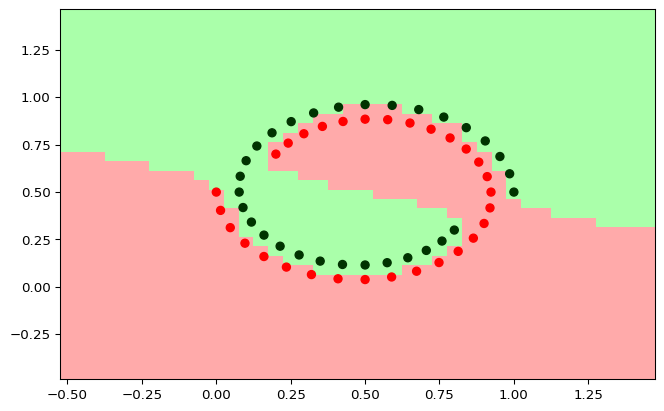

In [ ]:
C = [1, 100, 10000]

for c in C:
  svm = SVM(kernel = polynomial_kernel, C=c)
  svm.fit(X,y)
  plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

In this case, we need to set a very high value of C to have a reasonably good solution.

Let's try with a Gaussian Kernel:

     pcost       dcost       gap    pres   dres
 0: -5.9450e+01 -1.2314e+02  3e+02  1e+00  5e-15
 1: -4.8744e+01 -8.3263e+01  3e+01  4e-15  6e-15
 2: -5.8119e+01 -5.9974e+01  2e+00  2e-15  6e-15
 3: -5.9488e+01 -5.9508e+01  2e-02  4e-15  6e-15
 4: -5.9502e+01 -5.9503e+01  2e-04  5e-15  6e-15
 5: -5.9503e+01 -5.9503e+01  2e-06  1e-14  6e-15
Optimal solution found.
60 support vectors out of 60 points


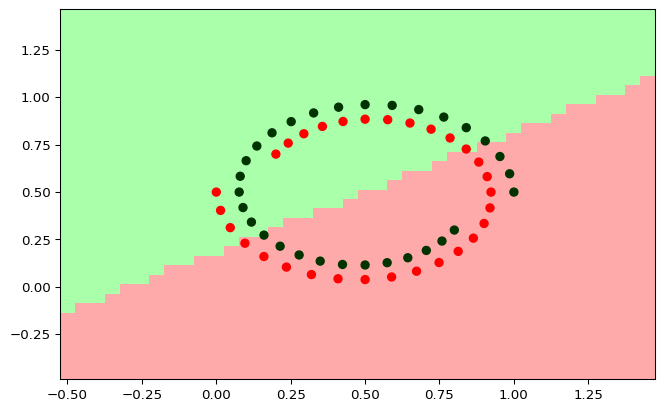

     pcost       dcost       gap    pres   dres
 0:  5.1979e+06 -1.8445e+08  2e+08  0e+00  2e-11
 1: -2.8387e+05 -5.1285e+06  5e+06  7e-12  3e-11
 2: -3.1848e+05 -7.4264e+05  4e+05  1e-16  3e-11
 3: -4.3862e+05 -6.3430e+05  2e+05  4e-11  3e-11
 4: -5.1088e+05 -5.4869e+05  4e+04  4e-11  3e-11
 5: -5.2132e+05 -5.3753e+05  2e+04  3e-11  4e-11
 6: -5.2708e+05 -5.3054e+05  3e+03  4e-11  5e-11
 7: -5.2825e+05 -5.2937e+05  1e+03  4e-11  4e-11
 8: -5.2857e+05 -5.2897e+05  4e+02  4e-11  4e-11
 9: -5.2875e+05 -5.2878e+05  3e+01  2e-11  5e-11
10: -5.2876e+05 -5.2876e+05  8e-01  2e-11  6e-11
11: -5.2876e+05 -5.2876e+05  3e-02  2e-11  6e-11
Optimal solution found.
60 support vectors out of 60 points


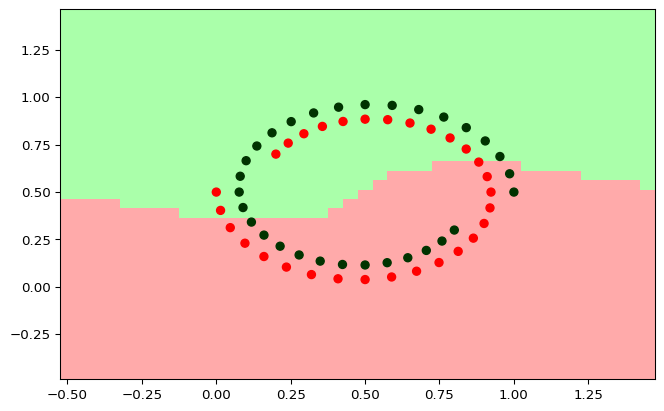

     pcost       dcost       gap    pres   dres
 0:  5.4922e+10 -1.8384e+12  2e+12  2e-17  2e-09
 1:  8.8683e+07 -4.6223e+10  5e+10  1e-09  3e-09
 2:  1.9686e+07 -8.1975e+08  8e+08  1e-16  3e-09
 3:  4.5123e+06 -9.9849e+07  1e+08  9e-10  2e-09
 4: -7.3094e+06 -2.4745e+07  2e+07  2e-09  3e-09
 5: -1.1163e+07 -1.5211e+07  4e+06  2e-09  2e-09
 6: -1.2384e+07 -1.3105e+07  7e+05  2e-16  2e-09
 7: -1.2622e+07 -1.2938e+07  3e+05  2e-09  2e-09
 8: -1.2761e+07 -1.2796e+07  3e+04  1e-09  2e-09
 9: -1.2774e+07 -1.2782e+07  8e+03  5e-10  2e-09
10: -1.2778e+07 -1.2778e+07  8e+01  2e-16  2e-09
11: -1.2778e+07 -1.2778e+07  8e-01  2e-09  1e-09
Optimal solution found.
60 support vectors out of 60 points


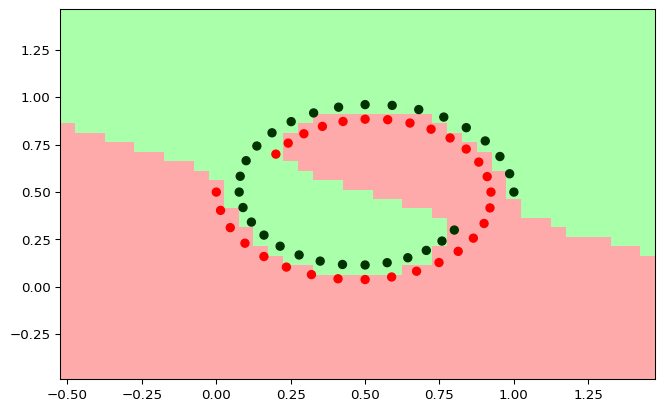

In [ ]:
C = [1, 10000, 1000000]

for c in C:
  svm = SVM(kernel = gaussian_kernel, C=c)
  svm.fit(X,y)
  plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=False)

Also in this case, we need very high values of C to get a good enough solution.
When using support vector machines on real data, it is important to try different kernels and choose the one that best fits our data. Moreover, we should carefully set the hyperparameter C such that we minimize the classification error on the validation set.

That's all!